# Data Exploration

In [1]:
library("car")
data("Leinhardt")

In [2]:
?Leinhardt

In [3]:
head(Leinhardt)

,income,infant,region,oil
Australia,3426,26.7,Asia,no
Austria,3350,23.7,Europe,no
Belgium,3346,17.0,Europe,no
Canada,4751,16.8,Americas,no
Denmark,5029,13.5,Europe,no
Finland,3312,10.1,Europe,no


In [4]:
str(Leinhardt)

'data.frame':	105 obs. of  4 variables:
 $ income: int  3426 3350 3346 4751 5029 3312 3403 5040 2009 2298 ...
 $ infant: num  26.7 23.7 17 16.8 13.5 10.1 12.9 20.4 17.8 25.7 ...
 $ region: Factor w/ 4 levels "Africa","Americas",..: 3 4 4 2 4 4 4 4 4 4 ...
 $ oil   : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...


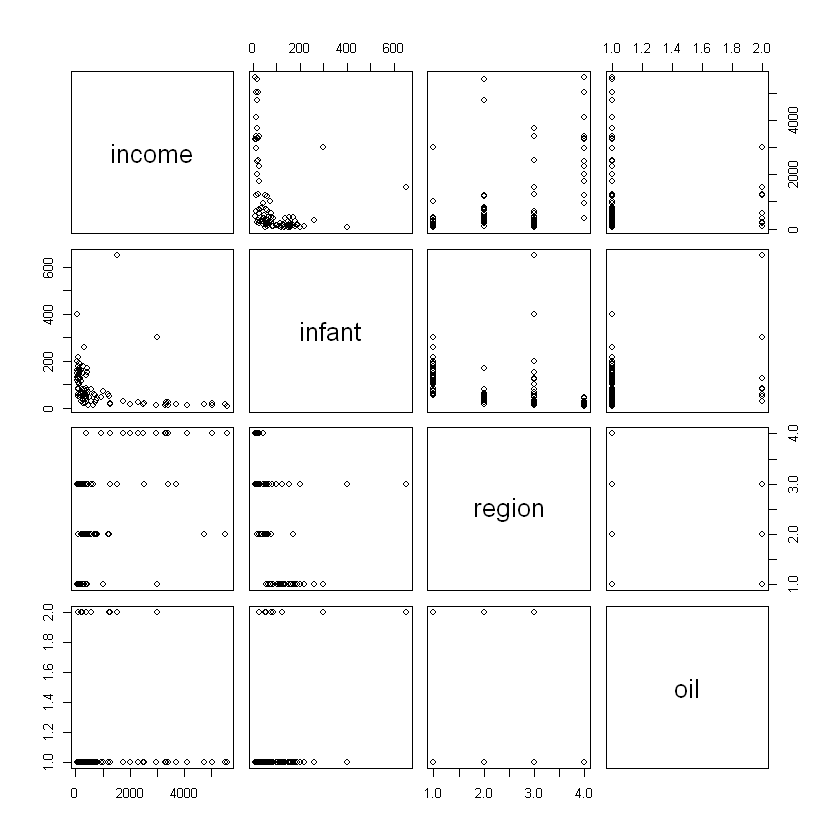

In [5]:
pairs(Leinhardt)

# Analysis

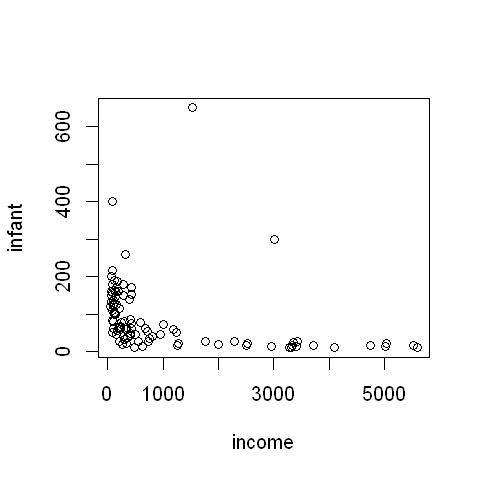

In [6]:
options(repr.plot.width=4, repr.plot.height=4)

plot(infant ~ income, data = Leinhardt)

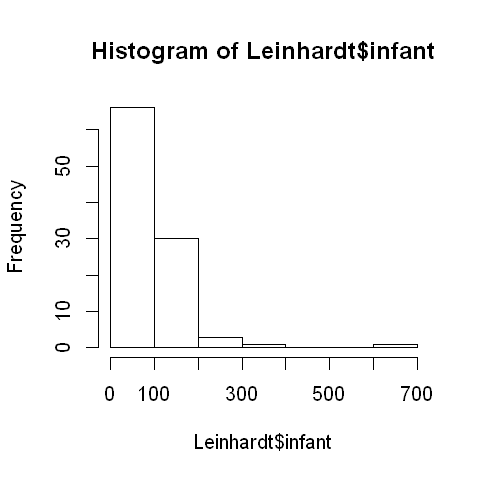

In [7]:
hist(Leinhardt$infant)

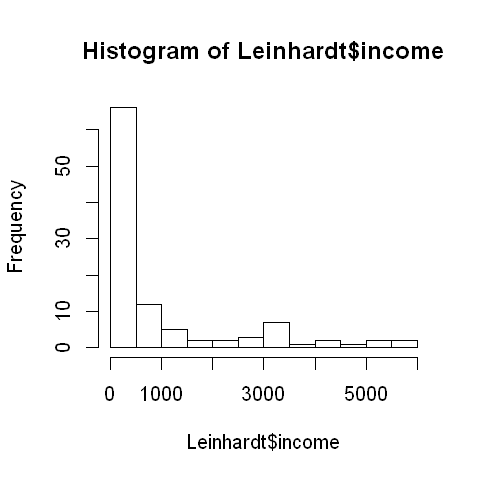

In [8]:
hist(Leinhardt$income)

In [9]:
# Linear Regression is not appropirate here cause both variables are right skewed. 
# But as therse variable are positively valued and very right skewed we can use log scale for further analysis.

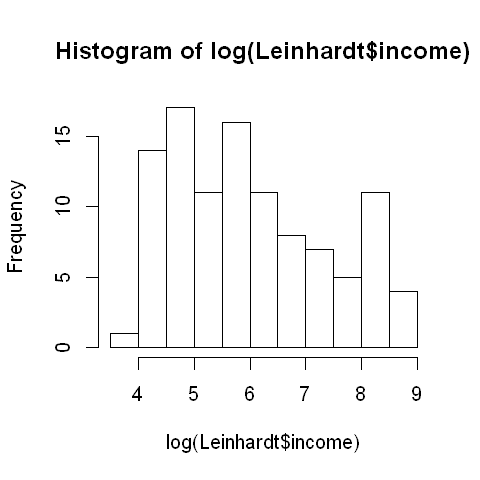

In [10]:
hist(log(Leinhardt$income))

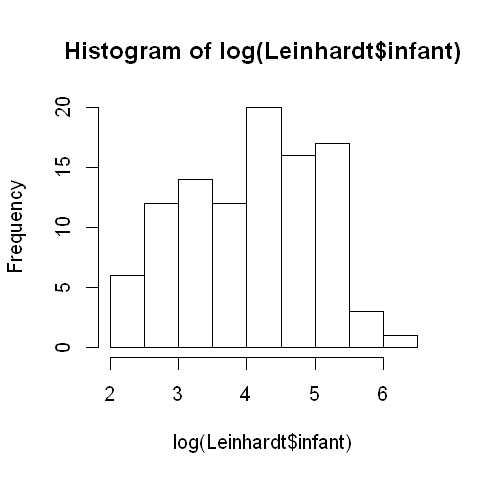

In [11]:
hist(log(Leinhardt$infant))

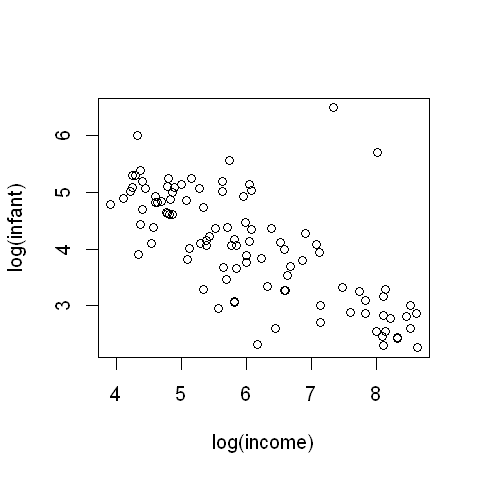

In [12]:
plot(log(infant) ~ log(income), data = Leinhardt)

In [13]:
# Now it's looking somewhat better.

# Modelling using R

In [14]:
lmod = lm(log(infant) ~ log(income), data = Leinhardt)

In [15]:
summary(lmod)


Call:
lm(formula = log(infant) ~ log(income), data = Leinhardt)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.66694 -0.42779 -0.02649  0.30441  3.08415 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.14582    0.31654  22.575   <2e-16 ***
log(income) -0.51179    0.05122  -9.992   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6867 on 99 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.5021,	Adjusted R-squared:  0.4971 
F-statistic: 99.84 on 1 and 99 DF,  p-value: < 2.2e-16


In [16]:
# Posterior mean estimates are very large relative to their standard error or here std. deviation of the posterior.
# Hence they apper to be statstically very significant.
# Residual error give use the value of left over variance after fitting the linear model.
# R squared statistics tells how much of variability is explained by linear model.

# [IMP]: (4 observations deleted due to missingn values. We can predict the value using supervised as well as 
#         unsupervised methods. But for now, I choose to ignore them.)

In [17]:
updated_df = na.omit(Leinhardt)

# Nepal, Iran, Haiti and Laos will not be include in this analysis.

# Modelling using JAGS

In [18]:
library("rjags")

Warning message:
"package 'rjags' was built under R version 3.4.4"Loading required package: coda
Warning message:
"package 'coda' was built under R version 3.4.4"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [19]:
# Hierarchical Model

mod1_str = " model {
    for (i in 1:n) {
        y[i] ~ dnorm(mu[i], prec)
        mu[i] = b[1] + b[2]*log_income[i] 
    }
    
    for (i in 1:2) {
        b[i] ~ dnorm(0.0, 1.0/1.0e6)
    }
    
    prec ~ dgamma(5/2.0, 5*10.0/2.0)
    sig2 = 1.0 / prec
    sig = sqrt(sig2)
} "

#Model is organizd in this hieracrchy [Likelikhood --> Priors]
# prec = 1/variance
# shape = prior_Sample_size/2.0
# rate = prior_sample_size*prior_guess/2.0

In [20]:
set.seed(72)

In [21]:
# Data required for the model.

data1_jags = list(y=log(updated_df$infant), n=nrow(updated_df), log_income=log(updated_df$income))

In [22]:
# Parameters that we want to monitor.

params1 = c("b", "sig")

In [23]:
# Initilie the model with some values.

inits1 = function() {
    inits = list("b"=rnorm(2,0.0,100.0), 
                 "prec"=rgamma(1,1.0,1.0))
}

In [24]:
mod1 = jags.model(textConnection(mod1_str), 
                  data=data1_jags, 
                  inits=inits1, 
                  n.chains=3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 3
   Total graph size: 404

Initializing model



In [25]:
# Give some burn in Period

In [26]:
update(mod1, 1000)

In [27]:
# Monte Carlo Simulation

mod1_sim = coda.samples(model = mod1, variable.names = params1, n.iter = 5e3)

In [28]:
# Combine the three different chains.

mod1_csim = do.call(rbind, mod1_sim)

# Convergence Dignosis of the Model

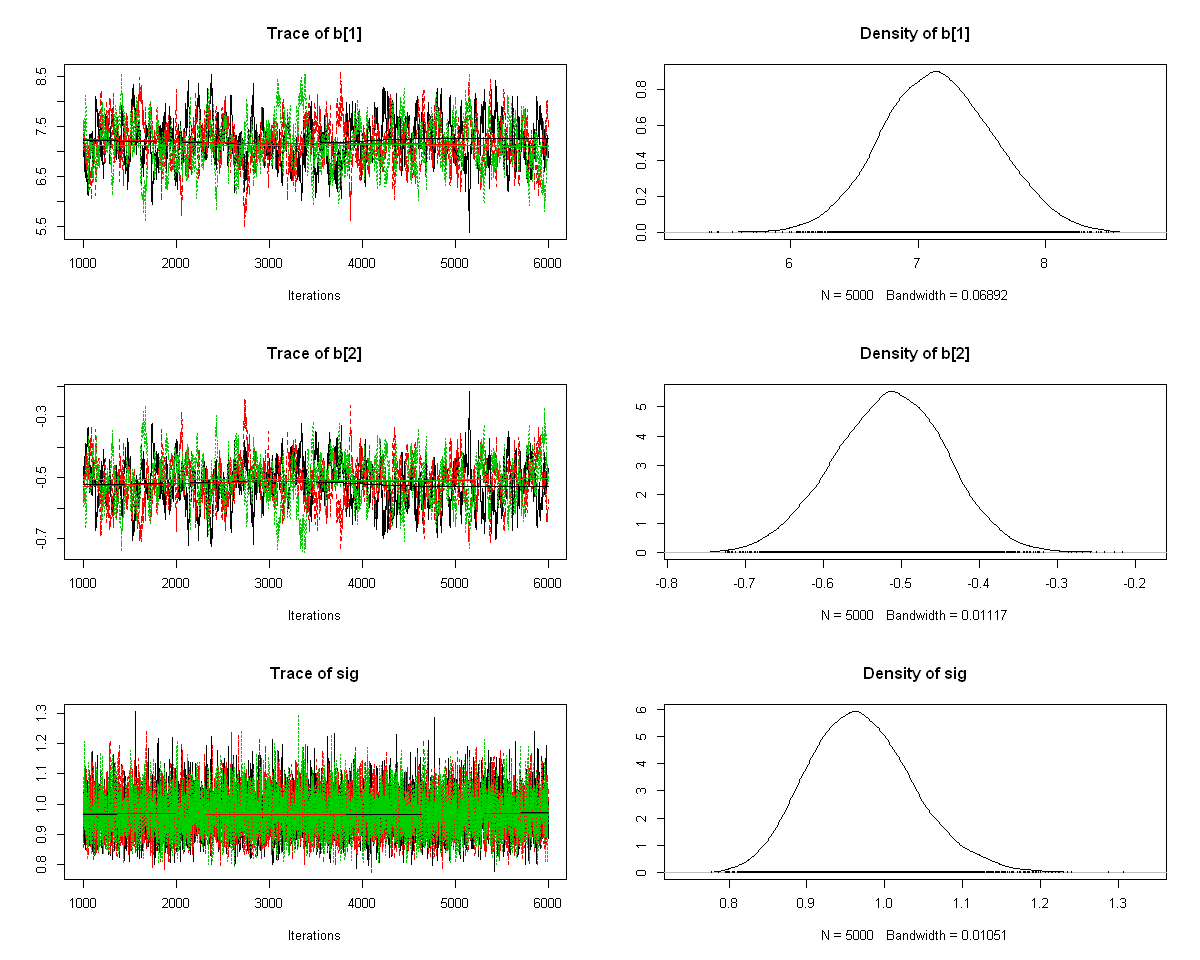

In [29]:
options(repr.plot.width=10, repr.plot.height=8)

plot(mod1_sim)

# Different colors represents different chains.
# We can see long term trends in these plot, so we can say we have done sufficient iterations.

In [30]:
gelman.diag(mod1_sim)

# Potential Scale reduction factor is close to 1 in cas of every parameter which indicates we probly have converged.

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]       1.01       1.01
b[2]       1.01       1.01
sig        1.00       1.00

Multivariate psrf

1

In [31]:
autocorr.diag(mod1_sim)

# Here we can see very high correlation in initial lags in case of b parameter.
# It suggest that we should check effective sample size.

,b[1],b[2],sig
Lag 0,1.00000000,1.00000000,1.000000000
Lag 1,0.95236395,0.95228633,0.017602158
Lag 5,0.78816986,0.78867993,0.005798127
Lag 10,0.62372507,0.62501191,0.016177745
Lag 50,0.09370111,0.09161941,-0.001506104


In [32]:
effectiveSize(mod1_sim)

# We ran 5000 itteration for 3 chains it means 15000 samples.
# These number below shows no of effective samples out of those samples.
# Sigma parameter has mixed very well but b1 and b2 didn't. Oneway to improve this is to run chain longer.

b[1]       b[2]        sig 
  365.9623   361.0822 12553.1494

In [33]:
summary(mod1_sim)

# This shows posterior summary.
# Iteration ranges from 1001:6000 which shows we spend first 1000 iteration in burn in ans saved the nexr 5000 samples.


Iterations = 1001:6000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
b[1]  7.1612 0.44491 0.0036327       0.023306
b[2] -0.5143 0.07211 0.0005888       0.003806
sig   0.9704 0.06810 0.0005560       0.000637

2. Quantiles for each variable:

        2.5%     25%     50%     75%   97.5%
b[1]  6.3083  6.8601  7.1524  7.4603  8.0396
b[2] -0.6574 -0.5632 -0.5132 -0.4652 -0.3759
sig   0.8488  0.9226  0.9664  1.0135  1.1167


In [34]:
# Let's compare this model with referece analysis.

summary(lmod)

# Intercept has to be comapred with b[1]
# Log(income) has to be compared with b[2]
# Residual Sd. error ahs to be compared with sig.
# There is some high varaition in Residual standard error and sig because we have used the 
# initial prior guess  of variance around 10. If our prior belief would be closer to real truth then
# sig would be closer to real residual standard error  for our posterior. But if we are not very confident
# it makes sense to lower our effective sample size.


Call:
lm(formula = log(infant) ~ log(income), data = Leinhardt)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.66694 -0.42779 -0.02649  0.30441  3.08415 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.14582    0.31654  22.575   <2e-16 ***
log(income) -0.51179    0.05122  -9.992   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6867 on 99 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.5021,	Adjusted R-squared:  0.4971 
F-statistic: 99.84 on 1 and 99 DF,  p-value: < 2.2e-16


# Residuals check for Untransformed Data

It will reveal the violation of our assumption we made to specify the model. Or in simple words we are checking wheather our model is linear or it is not normally distributed or the observatons are not independent from each other, at least conditionally on the explantory variables.

In [35]:
# Model on the untransformed data.

lmod0 = lm(infant ~ income, data=Leinhardt)

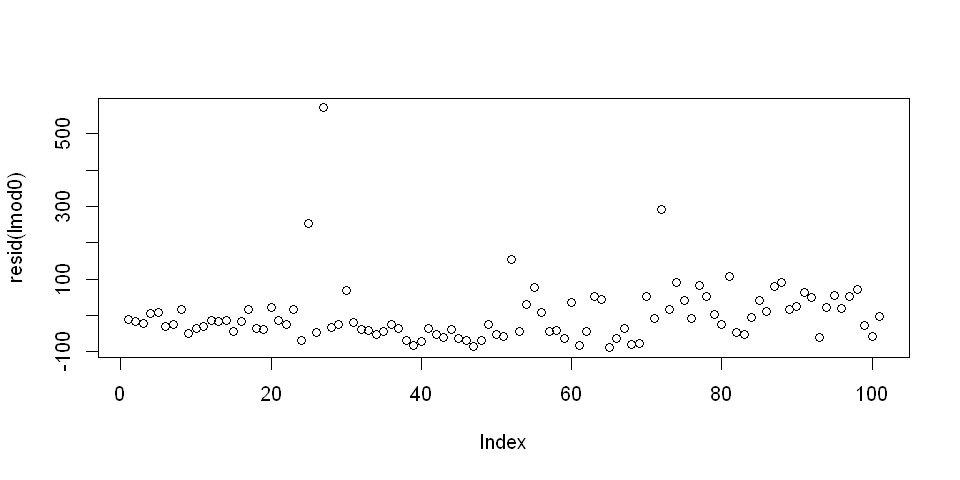

In [36]:
options(repr.plot.width=8, repr.plot.height=4)

plot(resid(lmod0))

# If data oints are not independent we might see a pattern in this plot. There doesn't seem much pattern here so we can assume
# it is somewhat independent.

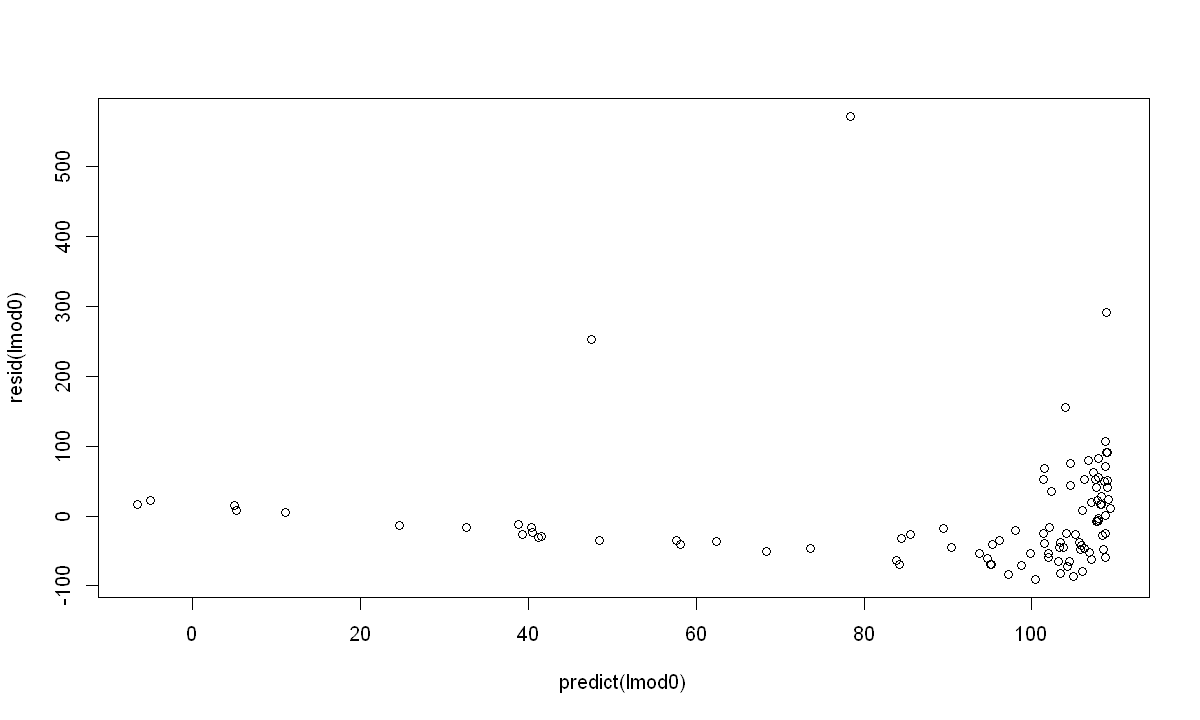

In [37]:
options(repr.plot.width=10, repr.plot.height=6)

plot(predict(lmod0), resid(lmod0))

# Here also we don't to obseve any pattern in the model. But here there lies a pattern. For values upto 80 there is
# decreasing pattern. And our assumption that the residual variance is the same for all observations appears to be 
# wildly incorrect in this case. For all of these predicted values on the left side of the plot the variance in the
# residuals is quite small, but for large predicted values, we have large variance.

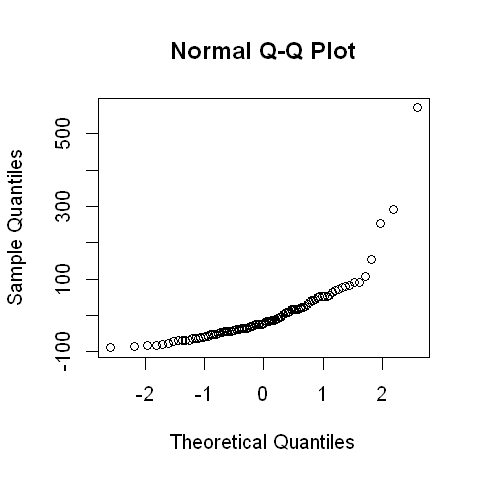

In [38]:
options(repr.plot.width=4, repr.plot.height=4)

qqnorm(resid(lmod0))
# This plot shows the theoretical quantiles or percentiles of an actual normal distribution on the x-axis with
# the sample quantiles of the residuals on the y-axis. If the residuals actually came from a normal distribution,
# the points on this plot would essentially follow a straight line. In this case, we have a curvature going up that
# increases and gets more extreme at the high values. This indicates that the residuals have a distribution that
# is right skewed and not normal. These plots that we've looked out so far are a bad example. They show us what
# that residual plots should not look like.

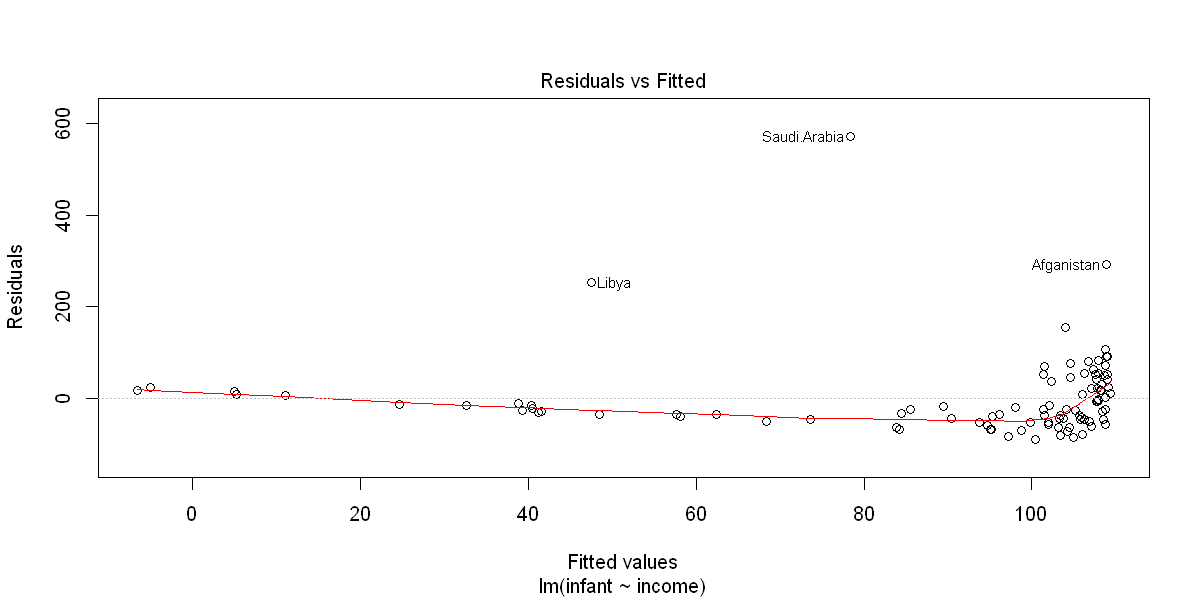

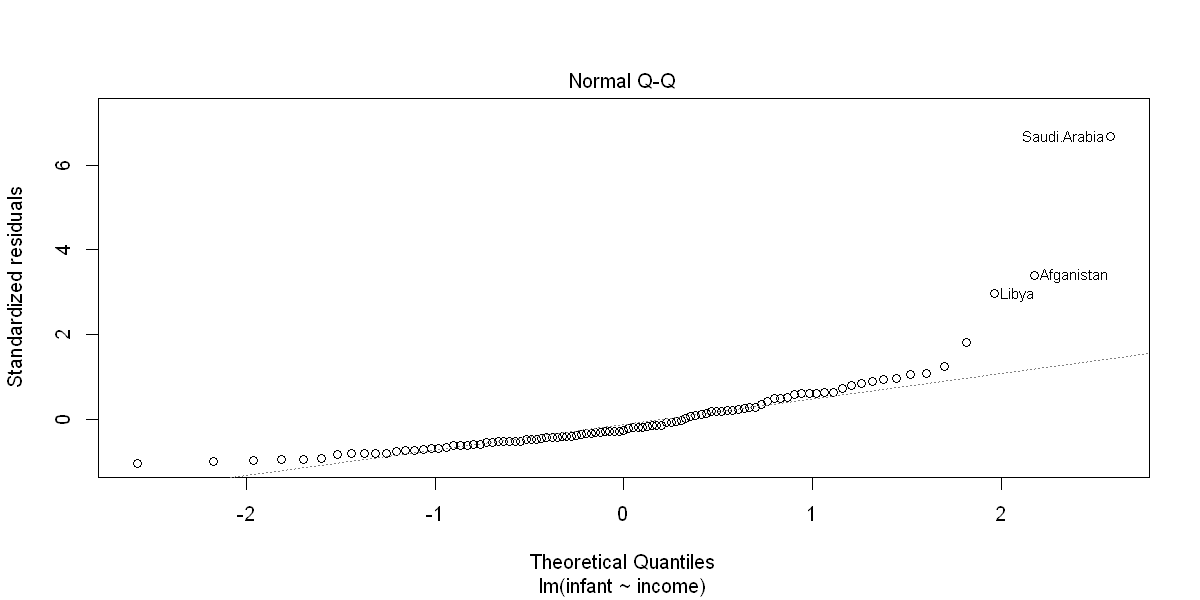

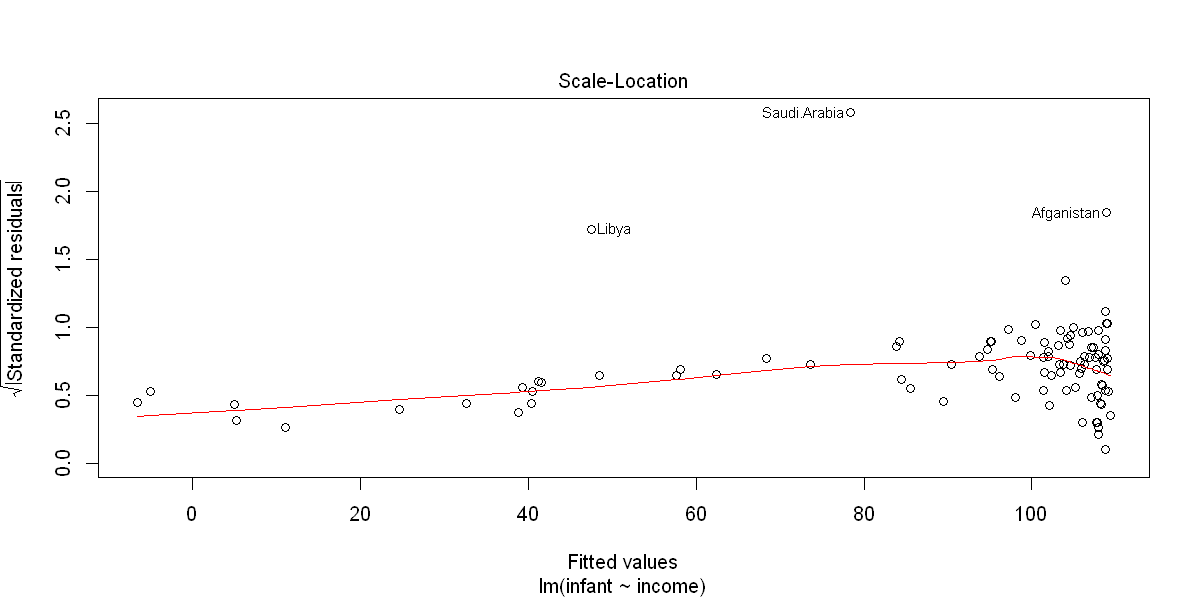

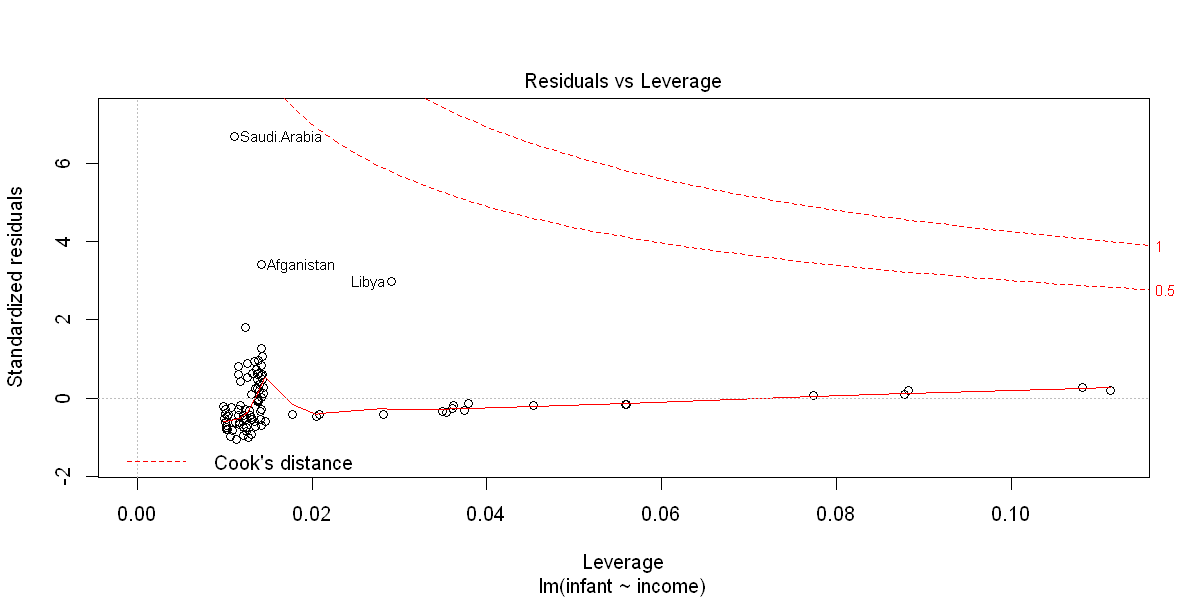

In [39]:
# We can simply draw all the graphs we plot above like this.

options(repr.plot.width=10, repr.plot.height=5)

plot(lmod0)

# Residuals check for Tranformed Data

Here I'm goinf to use residuals from our Bayesian model that I've fit in JAGS.
Predictions from Bayesian models come as posterior predictive distributions. So in reality, with the Bayesian model all residuals, or each residual, would have its own distribution. To simplify things a little bit and we can take a look at the residuals that come only from predictions based on the posterior means.

In [40]:
# Design Matrix

X = cbind(rep(1, data1_jags$n), data1_jags$log_income)
head(X)

1,8.139149
1,8.116716
1,8.115521
1,8.466110
1,8.522976
1,8.105308


In [41]:
# Posterior means of param1 which is column means of our combined simulations.

pm_params1 = colMeans(mod1_csim)

In [42]:
# Predicted value for the model.

yhat1 = drop(X %*% pm_params1[1:2])

In [43]:
resid1 = data1_jags$y - yhat1

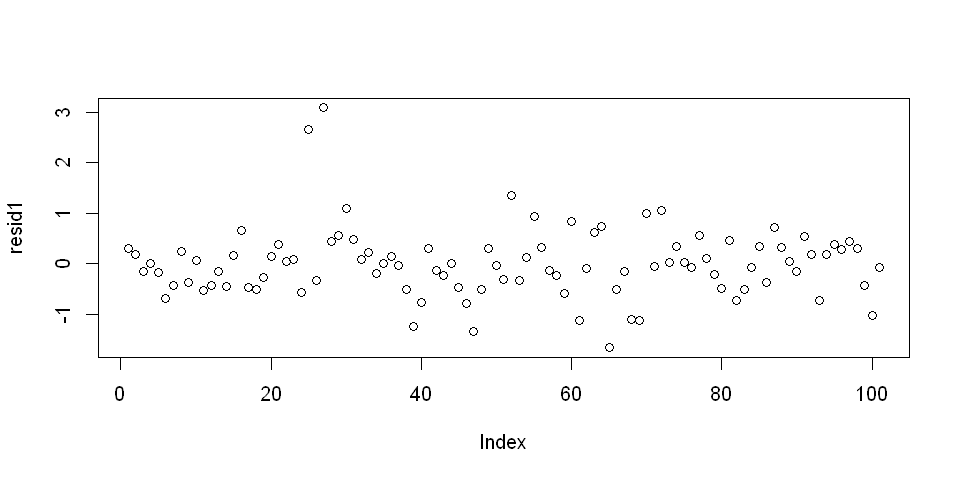

In [44]:
options(repr.plot.width=8, repr.plot.height=4)

plot(resid1)

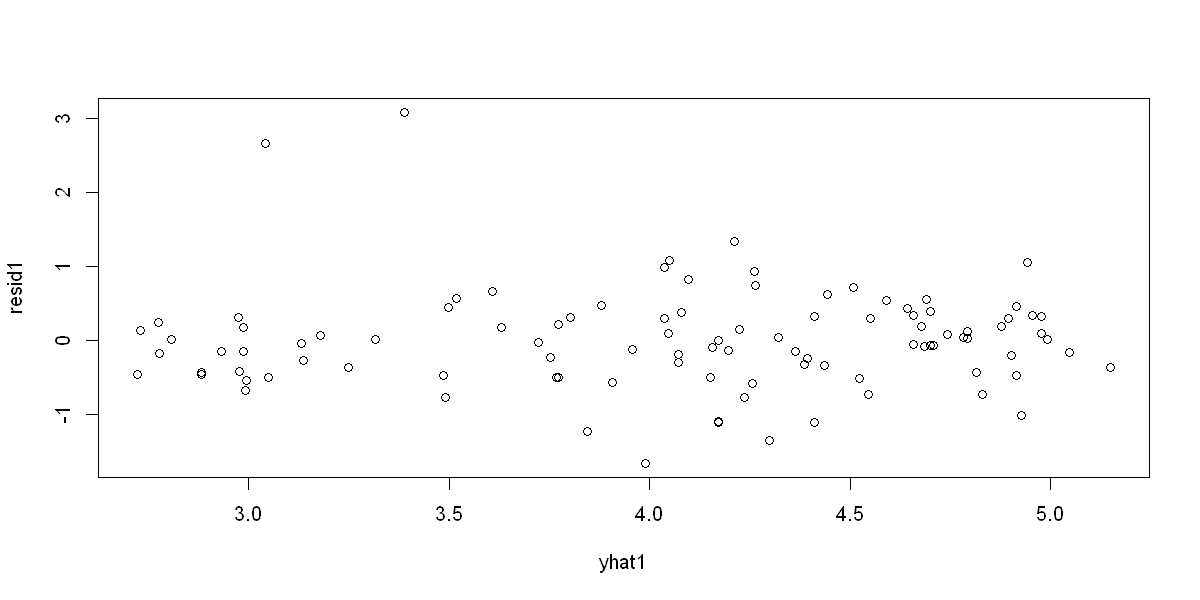

In [45]:
options(repr.plot.width=10, repr.plot.height=5)

plot(yhat1, resid1)

# Plot appear to have mean around 0. But only concern is that while going from left to right
# variance increases and there are two strong outliers here.

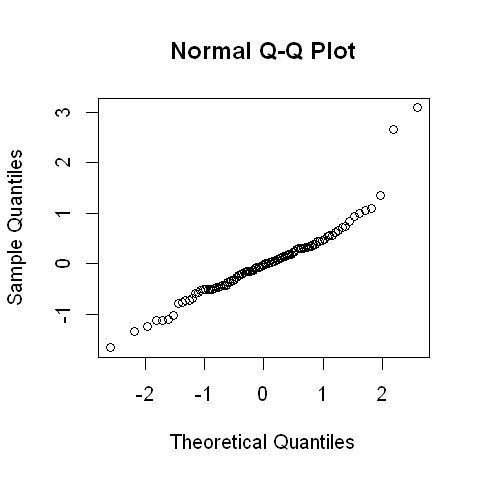

In [46]:
options(repr.plot.width=4, repr.plot.height=4)

qqnorm(resid1)

# If the resid1 comes from normal distribution that this plot will be linear, which seams quite reasonable in this case
# except for two outliers on the right most extreme values.

# Outliers

In [47]:
head(rownames(updated_df)[order(resid1, decreasing = TRUE)])

[1] "Saudi.Arabia" "Libya"        "Zambia"       "Brazil"       "Afganistan"  
[6] "Turkey"

In [48]:
# When outliers appear in your analysis, it is a good idea to double check that they are not just data errors 
# in your data entry. If the values are correct, you may reconsider whether these data points really are 
# representative of the data you were trying to model. If you conclude that they're not, for example, they were
# reported in different years, or they just don't belong, you may be able to justify dropping these data points 
# from the dataset. If you conclude that the outliers are part of the data and should not be removed, we have several 
# modeling options to accommodate them

# Outliers Handling Method I

Here we assume that outliers do belong to our data. So we are going to look for additional covariants or explanatory variables that maybe able to explain the outliers.

In [49]:
# Hierarchical Model

mod2_str = " model {
    for (i in 1:n) {
        y[i] ~ dnorm(mu[i], prec)
        mu[i] = b[1] + b[2]*log_income[i] + b[3]*is_oil[i] + b[4]*region[i]
    }
    
    for (i in 1:4) {
        b[i] ~ dnorm(0.0, 1.0/1.0e6)
    }
    
    prec ~ dgamma(5/2.0, 5*10.0/2.0)
    sig2 = 1.0 / prec
    sig = sqrt(sig2)
} "

# Here I've included new covarients ie is_oil and region.

In [50]:
set.seed(75)

In [51]:
# Parameters that we want to monitor.

params2 = c("b", "sig")

In [52]:
# Data required for the model.

regions_list = c("Africa", "Asia", "Europe", "Americas")

data2_jags = list(y=log(updated_df$infant), 
                  n=nrow(updated_df), 
                  log_income=log(updated_df$income),
                  is_oil=as.numeric(updated_df$oil == "yes"),
                  region= match(updated_df$region, regions_list)-1)

In [53]:
# Initilie the model with some values.

inits2 = function() {
    inits = list("b"=rnorm(4,0.0,100.0), 
                 "prec"=rgamma(1,1.0,1.0))
}

In [54]:
mod2 = jags.model(textConnection(mod2_str), 
                  data=data2_jags, 
                  inits=inits2, 
                  n.chains=3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 5
   Total graph size: 618

Initializing model



In [55]:
# Burn in

update(mod2, 2000)

In [56]:
# Monter Carlo Sampling

mod2_sim = coda.samples(model = mod2, variable.names = params2, n.iter = 1e4)

In [57]:
# Combine the three different chains.

mod2_csim = as.mcmc(do.call(rbind, mod2_sim))

#### Convergence Dignosis of the Model

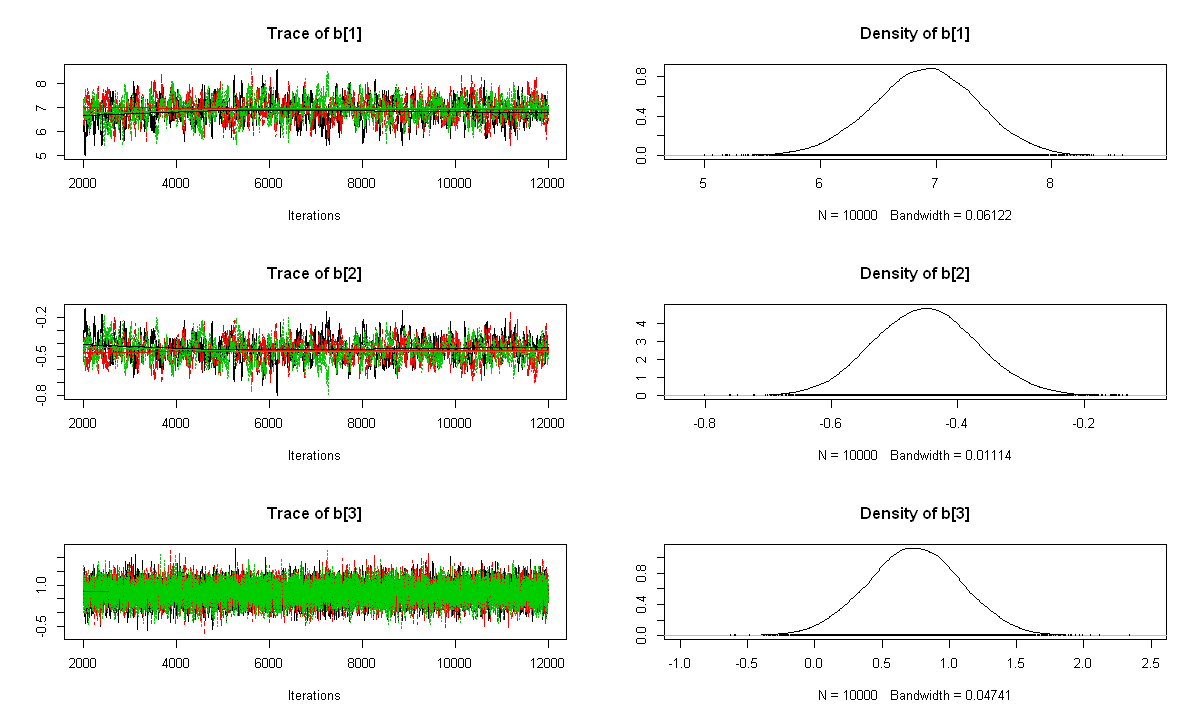

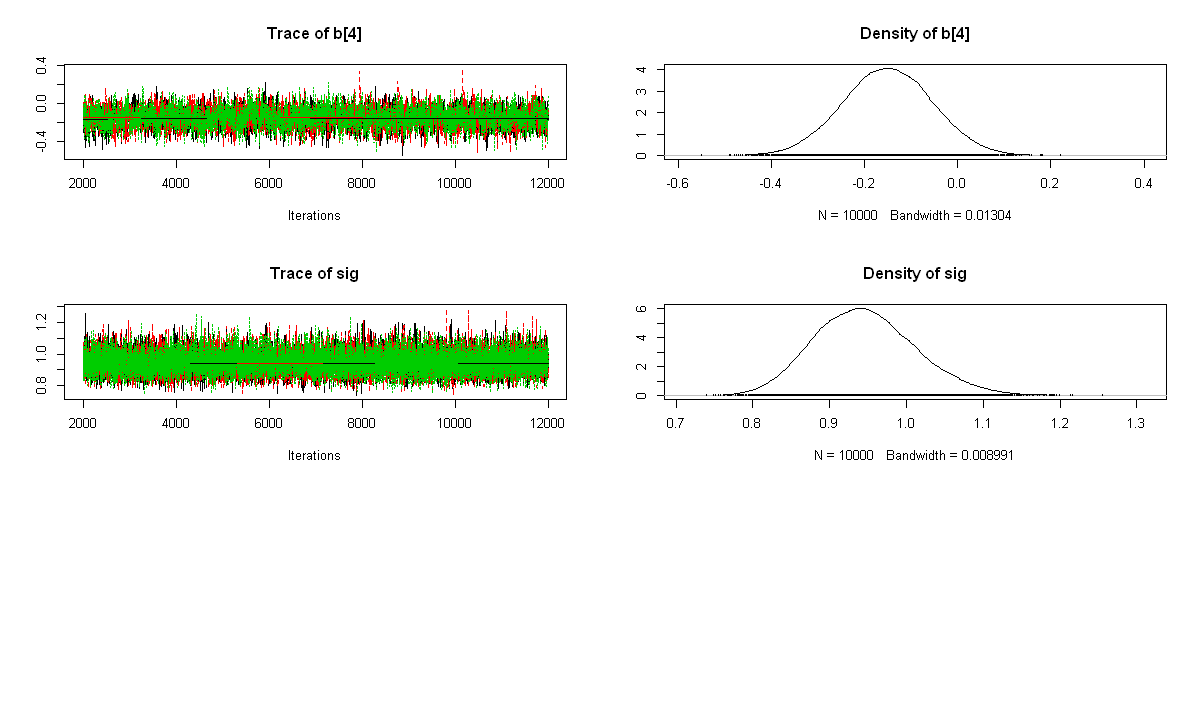

In [58]:
options(repr.plot.width=10, repr.plot.height=6)

plot(mod2_sim)

In [59]:
gelman.diag(mod2_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]       1.02       1.05
b[2]       1.02       1.05
b[3]       1.00       1.00
b[4]       1.00       1.01
sig        1.00       1.00

Multivariate psrf

1.01

In [60]:
autocorr.diag(mod2_sim)

,b[1],b[2],b[3],b[4],sig
Lag 0,1.0000000,1.0000000,1.000000000,1.00000000,1.000000000
Lag 1,0.9564708,0.9652590,0.091432729,0.67854096,0.030373145
Lag 5,0.8119661,0.8286711,0.001118090,0.23705844,0.005370749
Lag 10,0.6645404,0.6779657,0.001644161,0.12558601,-0.007194341
Lag 50,0.1460473,0.1520066,0.007017095,0.02642308,-0.002460509


In [61]:
effectiveSize(mod2_sim)

b[1]       b[2]       b[3]       b[4]        sig 
  598.9881   579.8966 24971.5771  2870.5086 24987.3034

#### Posterior Summary

In [62]:
summary(mod2_sim)


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
b[1]  6.9103 0.45493 0.0026266      0.0185230
b[2] -0.4507 0.08263 0.0004771      0.0034148
b[3]  0.7420 0.35500 0.0020496      0.0022466
b[4] -0.1500 0.09672 0.0005584      0.0018161
sig   0.9466 0.06679 0.0003856      0.0004232

2. Quantiles for each variable:

         2.5%     25%     50%      75%   97.5%
b[1]  6.00304  6.6112  6.9155  7.21945  7.7911
b[2] -0.61056 -0.5073 -0.4513 -0.39562 -0.2858
b[3]  0.04692  0.5068  0.7431  0.97788  1.4355
b[4] -0.33889 -0.2149 -0.1498 -0.08484  0.0386
sig   0.82613  0.8996  0.9430  0.98890  1.0876


#### Residual Analysis

In [63]:
# Design Matrix

X2 = cbind(rep(1, data2_jags$n), data2_jags$log_income, data2_jags$is_oil, data2_jags$region)
head(X2)

1,8.139149,0,1
1,8.116716,0,2
1,8.115521,0,2
1,8.466110,0,3
1,8.522976,0,2
1,8.105308,0,2


In [64]:
# Posterior means of param1 which is column means of our combined simulations.

pm_params2 = colMeans(mod2_csim)

In [65]:
# Predicted value for the model.

yhat2 = drop(X2 %*% pm_params2[1:4])

In [66]:
resid2 = data2_jags$y - yhat2

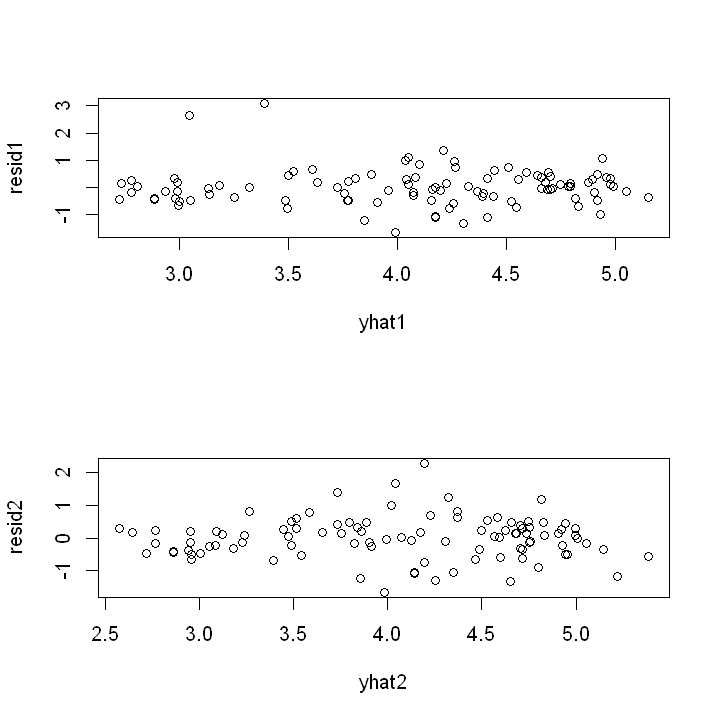

In [67]:
options(repr.plot.width=6, repr.plot.height=6)

# Comparsion of current result with the older result. Older result is on top.
par(mfrow = c(2,1))
plot(yhat1, resid1)
plot(yhat2, resid2)

# We can see the now outliers lies close to bulk of the data as compared to the old case.

# Outliers Handling Method II

To handle this situtaion we can change the underlyinh distribution that we are using for the model. We are using Noraml distribution in most of the probability is concentrated around the mean (within first few std. deviations). This doesn't accommodate outliers well. Usually such models are overly influenced with outliers. Here we should prefer t-distribution. 

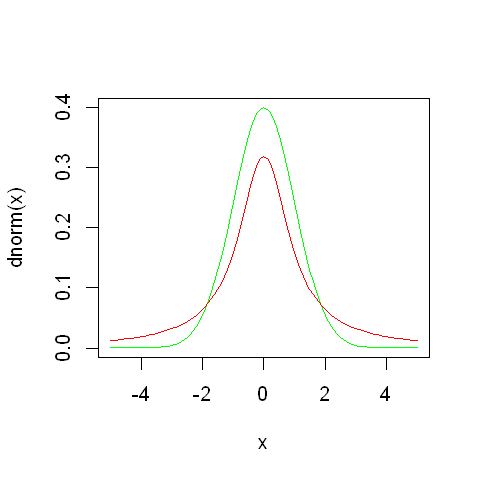

In [68]:
options(repr.plot.width=4, repr.plot.height=4)


curve(dnorm(x), from= -5, to= 5, col="green")
curve(dt(x, 1), from= -5, to= 5, col="red", add=TRUE)

In [94]:
# Hierarchical Model

mod3_str = " model {
    for (i in 1:length(y)) {
        y[i] ~ dt( mu[i], tau, df )
        mu[i] = b[1] + b[2]*log_income[i] + b[3]*is_oil[i] + b[4]*region[i]
    }
    
    for (i in 1:4) {
        b[i] ~ dnorm(0.0, 1.0/1.0e6)
    }
    
    df = nu + 2.0 # we want degrees of freedom > 2 to guarantee existence of mean and variance
    nu ~ dexp(1.0)
    
    tau ~ dgamma(5/2.0, 5*10.0/2.0) # tau is close to, but not equal to the precision
    sig = sqrt( 1.0 / tau * df / (df - 2.0) ) # standard deviation of errors
} "
# tau is inverse scale parameter.
# df is degree of freedom. More degree of freedom, heavier the tail will be.
# Here I've included new covarients i.e is_oil and region.

In [95]:
set.seed(79)

In [96]:
# Parameters that we want to monitor.

params3 = c("b", "sig")

In [97]:
# Data required for the model.

regions_list = c("Africa", "Asia", "Europe", "Americas")

data3_jags = list(y=log(updated_df$infant), 
                  n=nrow(updated_df), 
                  log_income=log(updated_df$income),
                  is_oil=as.numeric(updated_df$oil == "yes"),
                  region= match(updated_df$region, regions_list)-1)

In [100]:
# Initilie the model with some values.

inits3 = function() {
    inits = list("b"=rnorm(4,0.0,100.0), 
                 "tau"=rgamma(1,1.0,1.0),
                 "nu"=rexp(1, 1.0))
}

In [101]:
mod3 = jags.model(textConnection(mod3_str), 
                  data=data3_jags, 
                  inits=inits3, 
                  n.chains=3)

Warning message in jags.model(textConnection(mod3_str), data = data3_jags, inits = inits3, :
"Unused variable "n" in data"

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 6
   Total graph size: 622

Initializing model



In [102]:
# burn in

update(mod3, 1000)

In [103]:
#Monte Carlo Sampling

mod3_sim = coda.samples(model = mod3, variable.names = params3, n.iter = 5e3)

In [104]:
# Combining the chains

mod3_csim = as.mcmc(do.call(rbind, mod3_sim))

#### Convergence Dignosis of the Model

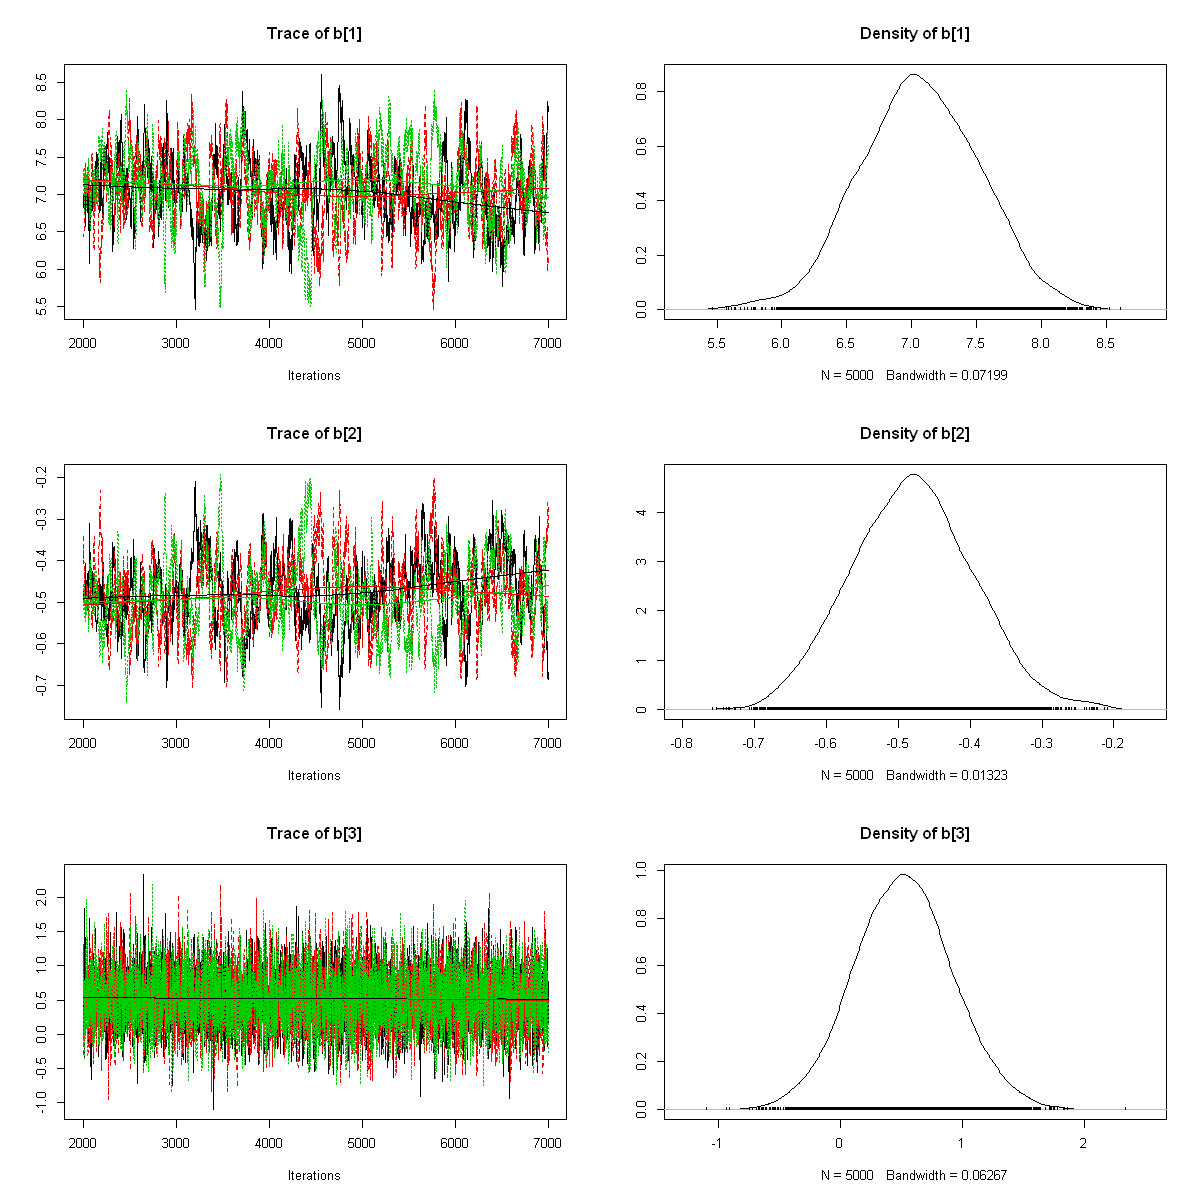

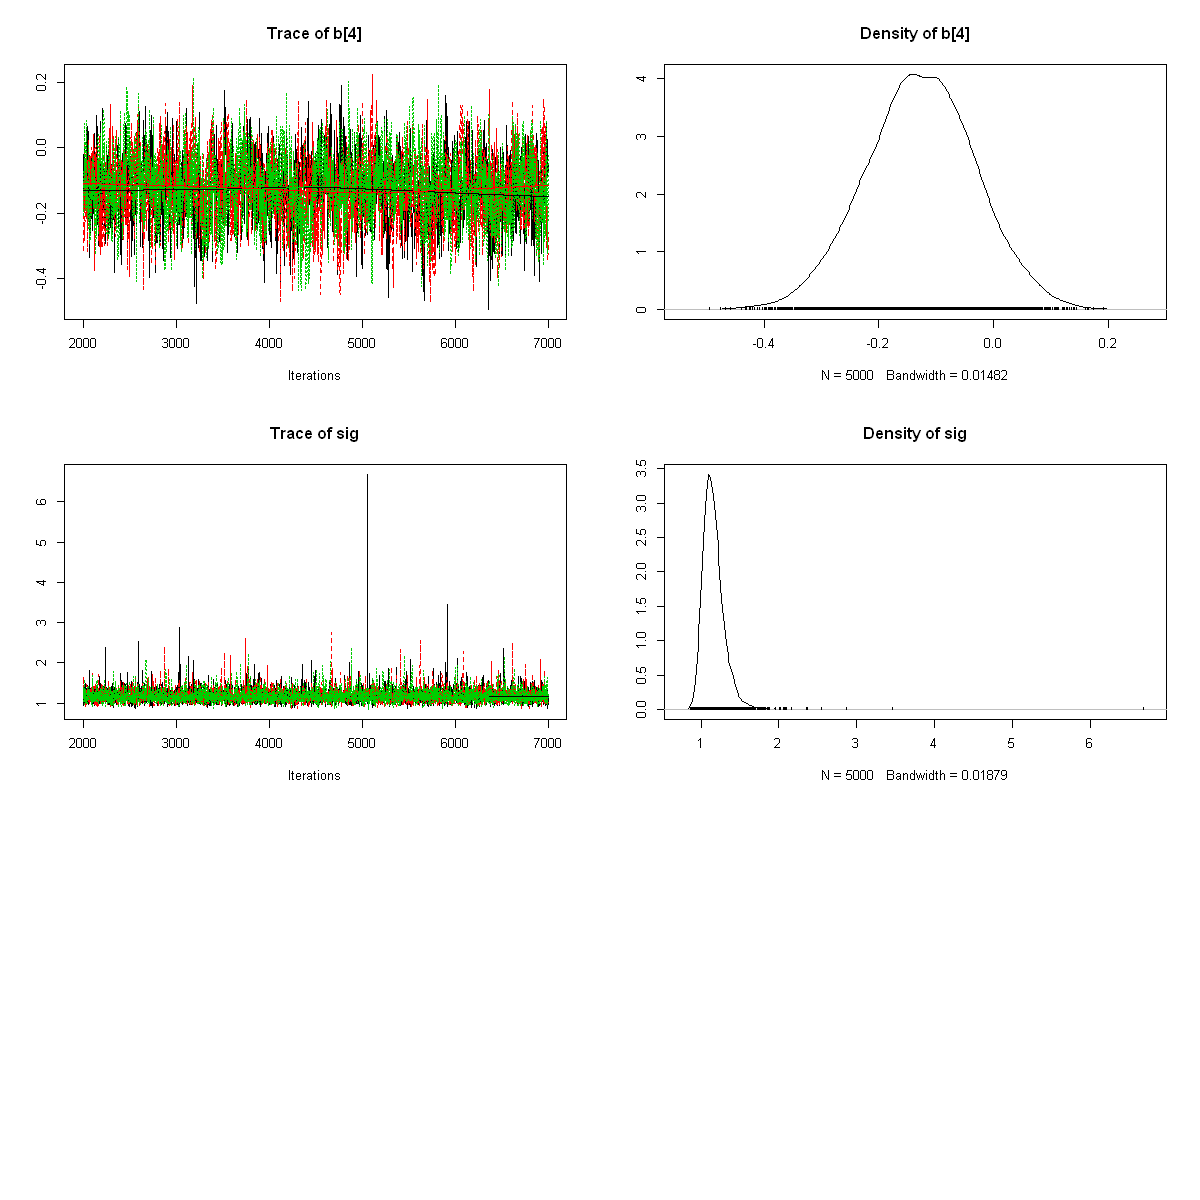

In [105]:
options(repr.plot.width=10, repr.plot.height=10)

plot(mod3_sim)

In [106]:
gelman.diag(mod3_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]       1.02       1.05
b[2]       1.01       1.05
b[3]       1.00       1.00
b[4]       1.00       1.01
sig        1.00       1.00

Multivariate psrf

1.01

In [107]:
autocorr.diag(mod3_sim)

,b[1],b[2],b[3],b[4],sig
Lag 0,1.0000000,1.0000000,1.0000000000,1.00000000,1.000000000
Lag 1,0.9658627,0.9722569,0.2452643905,0.74126756,0.213305000
Lag 5,0.8582386,0.8733161,0.0078920595,0.33872691,0.014506532
Lag 10,0.7397199,0.7579368,0.0088996226,0.22098898,-0.000418626
Lag 50,0.1958861,0.1984414,-0.0005766543,0.03443914,-0.003000223


In [108]:
effectiveSize(mod3_sim)

b[1]      b[2]      b[3]      b[4]       sig 
 223.5047  198.0643 8653.0232 1045.4807 9374.6777

#### Posterior Summary

In [109]:
summary(mod3_sim)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
b[1]  7.0651 0.46472 0.0037945       0.031404
b[2] -0.4803 0.08541 0.0006974       0.006086
b[3]  0.5194 0.40790 0.0033305       0.004432
b[4] -0.1269 0.09637 0.0007869       0.002982
sig   1.1648 0.15447 0.0012612       0.001612

2. Quantiles for each variable:

        2.5%     25%     50%      75%    97.5%
b[1]  6.1546  6.7539  7.0613  7.38668  7.95948
b[2] -0.6437 -0.5393 -0.4811 -0.42456 -0.30790
b[3] -0.2801  0.2453  0.5167  0.78735  1.33568
b[4] -0.3186 -0.1902 -0.1258 -0.06193  0.06117
sig   0.9544  1.0688  1.1424  1.23140  1.49802


#### Residual Analysis

In [110]:
# Design Matrix

X3 = cbind(rep(1, data3_jags$n), data3_jags$log_income, data3_jags$is_oil, data3_jags$region)
head(X3)

1,8.139149,0,1
1,8.116716,0,2
1,8.115521,0,2
1,8.466110,0,3
1,8.522976,0,2
1,8.105308,0,2


In [111]:
# Posterior means of param1 which is column means of our combined simulations.

pm_params3 = colMeans(mod3_csim)

In [113]:
# Predicted value for the model.

yhat3 = drop(X3 %*% pm_params3[1:4])

In [114]:
resid3 = data3_jags$y - yhat3

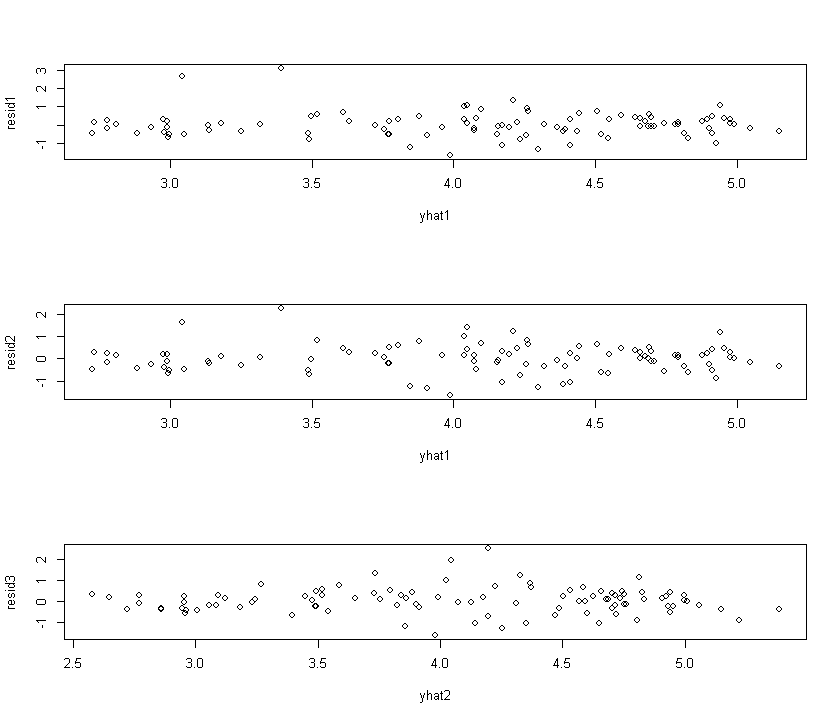

In [117]:
options(repr.plot.width=7, repr.plot.height=6)

# Comparsion of current result with the older result. Older result is on top.
par(mfrow = c(3,1))
plot(yhat1, resid1)
plot(yhat1, resid2)
plot(yhat2, resid3)

# We can see the now outliers lies close to bulk of the data as compared to the old case.

# Model Comparision using Deviance Information Criterion

The first number is the Monte Carlo estimated posterior mean deviance, which equals −2 times the log-likelihood (plus a constant that will be irrelevant for comparing models). Because of that −2 factor, a smaller deviance means a higher likelihood.

Next, we are given a penalty for the complexity of our model. This penalty is necessary because we can always increase the likelihood of the model by making it more complex to fit the data exactly. We don’t want to do this because over-fit models generalize poorly. This penalty is roughly equal to the effective number of parameters in your model. You can see this here. With the first model, we had a variance parameter and two betas, for a total of three parameters. In the second model, we added two more betas for the oil effect and to specify the region.

We add these two quantities to get the DIC (the last number). The better-fitting model has a lower DIC value. In this case, the gains we receive in deviance by adding the is_oil covariate outweigh the penalty for adding an extra parameter. The final DIC for the second model is lower than for the first and third, so we would prefer using the second model.

In [122]:
dic.samples(mod1, n.iter=1e3)

Mean deviance:  231.2 
penalty 3.019 
Penalized deviance: 234.2 

In [123]:
dic.samples(mod2, n.iter=1e3)

Mean deviance:  223.4 
penalty 4.769 
Penalized deviance: 228.2 

In [124]:
dic.samples(mod3, n.iter=1e3)

Mean deviance:  229.2 
penalty 4.655 
Penalized deviance: 233.9 